In [208]:
import LanusStats as ls
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import unicodedata
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

In [209]:
#Estadisticas de equipos del torneo actual

"""url_base = "https://fbref.com/es/comps/21/stats/Estadisticas-de-Liga-Profesional-Argentina#all_stats_standard"
request = requests.get(url_base)
html = request.text
soup = BeautifulSoup(html, "html.parser")

# Buscar la tabla específica
tabla = soup.find("table")  # Encuentra la primera tabla en la página
filas = tabla.find_all("tr")  # Todas las filas

data = []
for fila in filas:
    columnas = fila.find_all("td")# Buscar solo celdas de datos
    nombres = fila.find_all("a")
    #fila_datos = [columna.get_text(strip=True) for columna in columnas] # Extraer texto limpio
    fila_datos = []
    for nombre in nombres:
        fila_datos.append(nombre.get_text(strip=True))
        for columna in columnas:
            fila_datos.append(columna.get_text(strip=True))
    
    if fila_datos:  # Evitar agregar filas vacías
        data.append(fila_datos)

columnas = [th.get_text(strip=True) for th in filas[1].find_all("th")]  # Extraer encabezados
df_estadisticas = pd.DataFrame(data, columns=columnas)  # Omitir la primera columna si es índice
df_estadisticas = df_estadisticas[["Equipo", "Pos.", "G+A-TP", "TA", "TR"]]
mapeo = {"Estudiantes": "Estudiantes (LP)", "Gimnasia–LP": "Gimnasia y Esgrima (LP)", "Atlé Tucumán" : "Atlético Tucumán", "Arg Juniors" : "Argentinos Juniors"
            , "Cen. Córdoba–SdE" : "Central Córdoba (SdE)", "Newell's OB" : "Newell's Old Boys", "Defensa y Just" : "Defensa y Justicia", "Lanus" : "Lanús", "San Martin de San Juan" : "San Martín de San Juan"}
df_estadisticas["Equipo"] = df_estadisticas["Equipo"].replace(mapeo)

scaler = MinMaxScaler()
df_normalizado = df_estadisticas[["Pos.", "G+A-TP", "TA", "TR"]]
# Convert columns to numeric, forcing errors to NaN and then filling NaN with 0
df_estadisticas['Pos.'] = pd.to_numeric(df_estadisticas['Pos.'], errors='coerce').fillna(0)
df_estadisticas['G+A-TP'] = pd.to_numeric(df_estadisticas['G+A-TP'], errors='coerce').fillna(0)
df_estadisticas['TA'] = pd.to_numeric(df_estadisticas['TA'], errors='coerce').fillna(0)
df_estadisticas['TR'] = pd.to_numeric(df_estadisticas['TR'], errors='coerce').fillna(0)

df_estadisticas['Puntaje_TACT'] = (
    0.2 * df_estadisticas['Pos.'] +
    1.1 * df_estadisticas['G+A-TP'] -
    0.1 * df_estadisticas['TA'] -
    0.2 * df_estadisticas['TR']
)/10
#! TACT = TEMPORADA ACTUAL
df_estadisticas = df_estadisticas.sort_values(by='Puntaje_TACT', ascending=False)
df_estadisticas.to_csv("Estadisticas_actuales")"""

'url_base = "https://fbref.com/es/comps/21/stats/Estadisticas-de-Liga-Profesional-Argentina#all_stats_standard"\nrequest = requests.get(url_base)\nhtml = request.text\nsoup = BeautifulSoup(html, "html.parser")\n\n# Buscar la tabla específica\ntabla = soup.find("table")  # Encuentra la primera tabla en la página\nfilas = tabla.find_all("tr")  # Todas las filas\n\ndata = []\nfor fila in filas:\n    columnas = fila.find_all("td")# Buscar solo celdas de datos\n    nombres = fila.find_all("a")\n    #fila_datos = [columna.get_text(strip=True) for columna in columnas] # Extraer texto limpio\n    fila_datos = []\n    for nombre in nombres:\n        fila_datos.append(nombre.get_text(strip=True))\n        for columna in columnas:\n            fila_datos.append(columna.get_text(strip=True))\n    \n    if fila_datos:  # Evitar agregar filas vacías\n        data.append(fila_datos)\n\ncolumnas = [th.get_text(strip=True) for th in filas[1].find_all("th")]  # Extraer encabezados\ndf_estadisticas = pd.

In [210]:
#Importamos los datos
df_RTJ2024 = pd.read_csv('RTJ2024_y_Rendimiento3_torneos_anteriores.csv', index_col=0) #Rendimiento jugadores 2024 y rendimiento de los equipos en los 3 años anteriores
df_Historial_Partidos = pd.read_csv('Historial_partidos_porcentajes.csv', index_col=0) #Historial de partidos entre los equipos en forma porcdentual
df_Fixture = pd.read_csv('Fixture2025.csv', index_col=0) #Fixture 2025
df_estadisticas = pd.read_csv('Estadisticas_actuales', index_col=0) #Extraidas el 18/02

In [211]:
# Fusionamos el fixture con el historial de enfrentamientos

df_Fixture = df_Fixture.merge(df_Historial_Partidos, how="left", left_on=["Local", "Visitante"], right_on=["Equipo1", "Equipo2"])
df_Fixture.drop(columns=["Equipo1", "Equipo2"], inplace=True)

# Fusionamos el fixture con las estadisticas
df_merged = df_Fixture.merge(df_RTJ2024, left_on="Local", right_on="Equipo", how="left", suffixes=("_local", ""))
df_merged = df_merged.merge(df_estadisticas, left_on="Local", right_on="Equipo", how="left", suffixes=("_local", ""))
df_merged = df_merged.merge(df_RTJ2024, left_on="Visitante", right_on="Equipo", how="left", suffixes=("", "_visitante"))
df_mer = df_merged.merge(df_estadisticas, left_on="Visitante", right_on="Equipo", how="left", suffixes=("", "_visitante"))

#pd.set_option('display.max_columns', None)
df_merged = df_mer[["Fecha", "Local" , "Visitante" , "PJ" , "PV" , "PE", "PD", "PGF", "PGC","RTJ2024", "Puntaje_TACT" , "efectividad_L", "%victorias_L" , "%empates_L" , "%derrota_L" , "xg" ,"Puntaje_TACT_visitante",	"RTJ2024_visitante", "efectividad_V_visitante", "%victorias_V_visitante", "%empates_V_visitante", "%derrota_V_visitante", "xg_visitante"]]

def asignar_resultado(row):
    if row["PGF"] > row["PGC"]:
        return 1  # Gana local
    elif row["PGF"] < row["PGC"]:
        return 2  # Gana visitante
    else:
        return 0  # Empate
df_merged.replace(np.nan, 0, inplace=True)
df_merged["Resultado"] = df_merged.apply(asignar_resultado, axis=1)

def ajustar_goles_esperados(row):
    diferencia = abs(row["Puntaje_TACT"] - row["Puntaje_TACT_visitante"])
    
    # Si la diferencia es pequeña, acercamos los valores para incentivar el empate
    if diferencia < 0.3:
        ajuste = np.random.uniform(-0.2, 0.2)  # Pequeño ruido aleatorio
        row["Puntaje_TACT"] += ajuste
        row["Puntaje_TACT_visitante"] -= ajuste
    
    # Pequeño sesgo a favor del local
    row["Puntaje_TACT"] += 0.1  

    return row

df_merged = df_merged.apply(ajustar_goles_esperados, axis=1)

# Ahora sí aplicás Poisson con los valores ajustados
df_merged["PGF_ajustado"] = np.random.poisson(df_merged["Puntaje_TACT"] * 1.1)  # Más goles para locales
df_merged["PGC_ajustado"] = np.random.poisson(df_merged["Puntaje_TACT_visitante"] * 0.9)


In [212]:
# Definir variables predictoras (sin incluir los goles reales)
X = df_merged[["PV", "PE", "PD", "Puntaje_TACT" , "RTJ2024" , "efectividad_L", "%victorias_L" , "%empates_L" , "%derrota_L"  , "xg" ,	"Puntaje_TACT_visitante",	"RTJ2024_visitante", "efectividad_V_visitante", "%victorias_V_visitante", "%empates_V_visitante", "%derrota_V_visitante", "xg_visitante"]]

# Variables objetivo (goles locales y visitantes)
y_local = df_merged["PGF_ajustado"]  # Goles marcados por el equipo local
y_visitante = df_merged["PGC_ajustado"]  # Goles marcados por el equipo visitante

# Dividir en train-test
X_train, X_test, y_train_local, y_test_local = train_test_split(X, y_local, test_size=0.2, random_state=42)
X_train, X_test, y_train_visitante, y_test_visitante = train_test_split(X, y_visitante, test_size=0.2, random_state=42)

# Entrenar modelos
modelo_local = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_local.fit(X_train, y_train_local)

modelo_visitante = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_visitante.fit(X_train, y_train_visitante)

# Predicciones
df_merged["Pred_Goles_Local"] = modelo_local.predict(X)
df_merged["Pred_Goles_Visitante"] = modelo_visitante.predict(X)

In [213]:
umbral_empate = 0.4  # Se puede ajustar

def ajustar_resultado(row, umbral=umbral_empate):
    diferencia = abs(row["PGF_ajustado"] - row["PGC_ajustado"])
    
    if diferencia < umbral:
        return 0  # Empate
    elif row["PGF_ajustado"] > row["PGC_ajustado"]:
        return 1  # Victoria local
    else:
        return 2  # Victoria visitante

def calcular_resultado(row, umbral=umbral_empate):
    diferencia = abs(row["Pred_Goles_Local"] - row["Pred_Goles_Visitante"])
    
    if diferencia < umbral:
        return 0  # Empate
    elif row["Pred_Goles_Local"] > row["Pred_Goles_Visitante"]:
        return 1  # Victoria local
    else:
        return 2  # Victoria visitante

df_merged["Resultado_Ajustado"] = df_merged.apply(lambda row: ajustar_resultado(row, umbral_empate), axis=1)
df_merged["Pred_Resultado"] = df_merged.apply(lambda row: calcular_resultado(row, umbral_empate), axis=1)

In [214]:
mae_local = mean_absolute_error(df_merged["PGF_ajustado"], df_merged["Pred_Goles_Local"])
mae_visitante = mean_absolute_error(df_merged["PGC_ajustado"], df_merged["Pred_Goles_Visitante"])
accuracy = accuracy_score(df_merged["Resultado_Ajustado"], df_merged["Pred_Resultado"])

print(f"Error promedio en goles del local: {mae_local:.2f}")
print(f"Error promedio en goles del visitante: {mae_visitante:.2f}")
print(f"Precisión en el pronóstico de resultados: {accuracy:.2%}")

Error promedio en goles del local: 0.57
Error promedio en goles del visitante: 0.48
Precisión en el pronóstico de resultados: 73.75%


In [215]:
# Tabla general
equipos = set(df_Fixture["Local"]).union(set(df_Fixture["Visitante"]))  # Lista de equipos
tabla = pd.DataFrame({"Equipo": list(equipos)})
tabla["Puntos"] = 0
tabla["Partidos_Jugados"] = 0

for _, partido in df_merged.iterrows():
    local, visitante = partido["Local"], partido["Visitante"]
    resultado = partido["Pred_Resultado"]  # 0 = Empate, 1 = Local gana, 2 = Visitante gana
    
    # Buscar en la tabla de posiciones
    idx_local = tabla.index[tabla["Equipo"] == local][0]
    idx_visitante = tabla.index[tabla["Equipo"] == visitante][0]
    
    # Asignacion de puntos segun la prediccion
    if resultado == 1:  # Victoria local
        tabla.loc[idx_local, "Puntos"] += 3
    elif resultado == 2:  # Victoria visitante
        tabla.loc[idx_visitante, "Puntos"] += 3
    else:  # Empate
        tabla.loc[idx_local, "Puntos"] += 1
        tabla.loc[idx_visitante, "Puntos"] += 1
    
    # Suma de puntos
    tabla.loc[idx_local, "Partidos_Jugados"] += 1
    tabla.loc[idx_visitante, "Partidos_Jugados"] += 1

tabla = tabla.sort_values(by=["Puntos"], ascending=False).reset_index(drop=True)

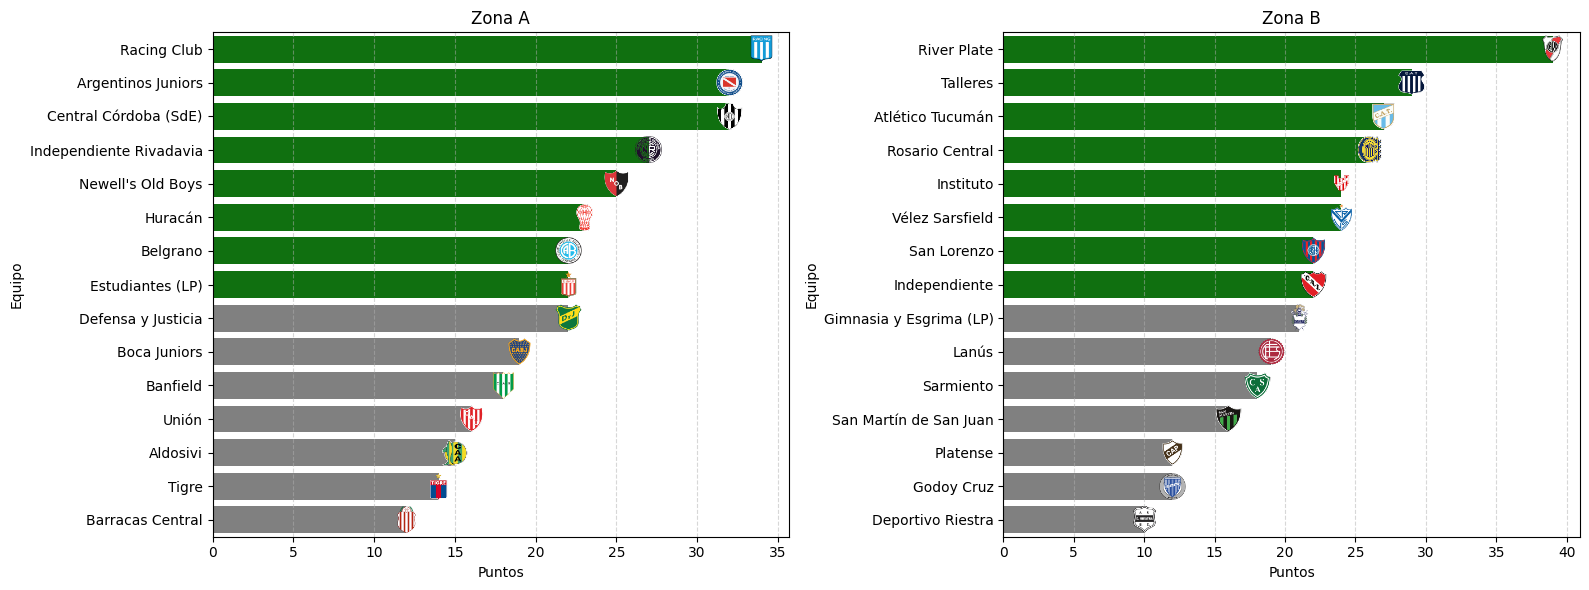

In [216]:
equipos_zonaA = ['Argentinos Juniors', 'Central Córdoba (SdE)', 'Estudiantes (LP)', 'Tigre', 'Defensa y Justicia', 'Boca Juniors', 'Racing Club', 'Barracas Central', 'Independiente Rivadavia','Banfield', 'Huracán', 'Belgrano',  "Newell's Old Boys",'Unión','Aldosivi']
equipos_zonaB = [equipo for equipo in equipos if equipo not in equipos_zonaA]

# Crear la figura con dos gráficos en una fila (ncols=2)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))  # (Filas, Columnas)


# 📌 1️⃣ **Primer gráfico: Tabla de posiciones**
df_posiciones = tablaA = tabla[tabla["Equipo"].isin(equipos_zonaA)]
df_posiciones = df_posiciones.sort_values(by=["Puntos"], ascending=False).reset_index(drop=True)
colores1 = np.where(df_posiciones.index < 8, "green", "gray")

sns.barplot(y=df_posiciones["Equipo"], x=df_posiciones["Puntos"], palette=colores1, ax=axes[0])
axes[0].set_title("Zona A")
axes[0].set_xlabel("Puntos")
axes[0].set_ylabel("Equipo")
axes[0].grid(axis="x", linestyle="--", alpha=0.5)

# 📌 2️⃣ **Segundo gráfico: Otra tabla (Ejemplo: Diferencia de Goles)**
df_posicionesB = tablaB = tabla[tabla["Equipo"].isin(equipos_zonaB)]
df_posicionesB = df_posicionesB.sort_values(by=["Puntos"], ascending=False).reset_index(drop=True)
colores2 = np.where(df_posicionesB.index < 8, "green", "gray")

sns.barplot(y=df_posicionesB["Equipo"], x=df_posicionesB["Puntos"], palette=colores2, ax=axes[1])
axes[1].set_title("Zona B")
axes[1].set_xlabel("Puntos")
axes[1].set_ylabel("Equipo")
axes[1].grid(axis="x", linestyle="--", alpha=0.5)

# 🔹 Función para agregar logos
def get_image(path, zoom=0.40):
    try:
        img = Image.open(path)
        return OffsetImage(img, zoom=zoom, alpha=1)
    except:
        return None

# 📌 Agregar logos a ambos gráficos
for i, equipo in enumerate(df_posiciones["Equipo"]):
    logo_path = f"logos/{equipo}.png"
    if os.path.exists(logo_path):
        imagebox = AnnotationBbox(get_image(logo_path), 
                                (df_posiciones["Puntos"].iloc[i], i),  
                                frameon=False, 
                                xycoords="data", 
                                boxcoords="data", 
                                pad=0.3)  
        axes[0].add_artist(imagebox)

for i, equipo in enumerate(df_posicionesB["Equipo"]):
    logo_path = f"logos/{equipo}.png"
    if os.path.exists(logo_path):
        imagebox = AnnotationBbox(get_image(logo_path), 
                                (df_posicionesB["Puntos"].iloc[i], i),  
                                frameon=False, 
                                xycoords="data", 
                                boxcoords="data", 
                                pad=0.3)  
        axes[1].add_artist(imagebox)

# 📌 Ajustar márgenes y mostrar
plt.tight_layout()
plt.show()

In [217]:
def eliminatorias(df_ronda_anterior):
    #Cuartos de final
    df_merged_octavos = df_ronda_anterior
    Equipos = []
    for _, partido in df_ronda_anterior.iterrows():
        local, visitante = partido["Equipo1"], partido["Equipo2"]
        resultado = partido["Pred_Resultado"]  # 0 = Empate, 1 = Local gana, 2 = Visitante gana
        # Asignar puntos según la predicción
        if resultado == 1:  # Victoria local
            Equipos.append(local)
        elif resultado == 2:  # Victoria visitante
            Equipos.append(visitante)

    equipo1 = []
    equipo2 = []

    for i in range(0, len(Equipos), 2):
        equipo1.append(Equipos[i])
        equipo2.append(Equipos[i+1])
        
    Ronda_actual = pd.DataFrame({"Equipo1": equipo1,
                            "Equipo2": equipo2
                            })

    df_ronda_actual = Ronda_actual.merge(df_Historial_Partidos, how="left", left_on=["Equipo1", "Equipo2"], right_on=["Equipo1", "Equipo2"])
    df_ronda_actual = df_ronda_actual.merge(df_RTJ2024, left_on="Equipo1", right_on="Equipo", how="left", suffixes=("_local", ""))
    df_ronda_actual = df_ronda_actual.merge(df_estadisticas, left_on="Equipo1", right_on="Equipo", how="left", suffixes=("_local", ""))
    df_ronda_actual = df_ronda_actual.merge(df_RTJ2024, left_on="Equipo2", right_on="Equipo", how="left", suffixes=("", "_visitante"))
    df_ronda_actual = df_ronda_actual.merge(df_estadisticas, left_on="Equipo2", right_on="Equipo", how="left", suffixes=("", "_visitante"))
    df_ronda_actual.drop(columns=["Equipo_local", "Equipo_visitante"], inplace=True)

    #Prediccion
    X_cuartos = df_ronda_actual[["PV", "PE", "PD", "Puntaje_TACT" , "RTJ2024" , "efectividad_L", "%victorias_L" , "%empates_L" , "%derrota_L"  , "xg" ,	"Puntaje_TACT_visitante",	"RTJ2024_visitante", "efectividad_V_visitante", "%victorias_V_visitante", "%empates_V_visitante", "%derrota_V_visitante", "xg_visitante"]]
    df_ronda_actual["Pred_Goles_Local"] = modelo_local.predict(X_cuartos)
    df_ronda_actual["Pred_Goles_Visitante"] = modelo_visitante.predict(X_cuartos)*1.1
    umbral_empate = 0
    df_ronda_actual["Pred_Resultado"] = df_ronda_actual.apply(lambda row: calcular_resultado(row, umbral_empate), axis=1)
    df_ronda_actual["Vs"] = "Vs."
    return df_ronda_actual

In [ ]:
def grafico_eliminatoria(df):

    fig, ax = plt.subplots(figsize=(8, len(df)))

    y_offset = 2  # Espacio entre enfrentamientos

    # Dibujar enfrentamientos con cuadros y ganador
    for i, row in df.iterrows():
        y = -i * y_offset  # Posición vertical
        team1, team2, ganador = row["Equipo1"], row["Equipo2"], row["Pred_Resultado"]

        # Recuadros equipos
        ax.text(0, y, team1, ha='right', fontsize=10, fontweight="bold", bbox=dict(facecolor='lightgray', edgecolor='black'))
        ax.text(0, y - 1, team2, ha='right', fontsize=10, fontweight="bold", bbox=dict(facecolor='lightgray', edgecolor='black'))

        # Lineas de conexion
        ax.plot([0.1, 0.4], [y, y], 'k-')
        ax.plot([0.1, 0.4], [y - 1, y - 1], 'k-')
        ax.plot([0.4, 0.4], [y, y - 1], 'k-')

        # Ganador
        ganador_y = y if ganador == 1 else y - 0.5
        ax.text(0.5, ganador_y, team1 if ganador == 1 else team2, ha='left', fontsize=10, fontweight="bold",
                bbox=dict(facecolor='yellow', edgecolor='black'))  # Resalta el ganador

        # Línea conectando al ganador a la siguiente ronda
        ax.plot([0.4, 0.6], [ganador_y, ganador_y], 'k-')

    # Ejes
    ax.set_xlim(-0.2, 1)
    ax.set_ylim(-len(df) * y_offset + 0.5, 1)
    ax.axis("off")  # Ocultar ejes

    if len(df) == 8:
        titulo = "Octavos de Final"
    elif len(df) == 4:
        titulo = "Cuartos de Final"
    elif len(df) == 2:
        titulo = "Semifinal"
    elif len(df) == 1:
        titulo = "Final"
    
    plt.title(titulo, fontsize=14, fontweight="bold")
    return plt.show()

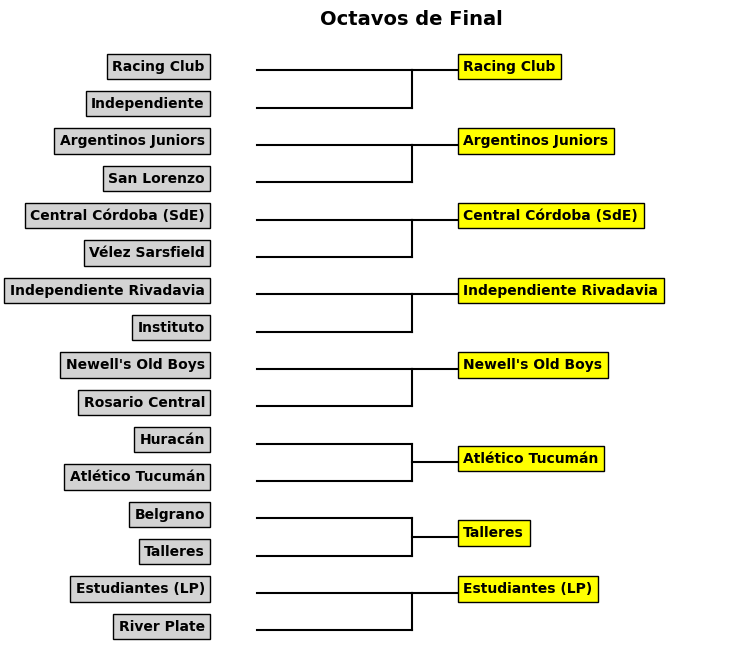

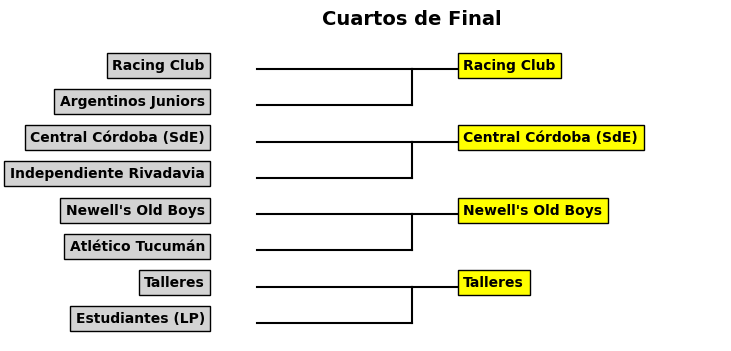

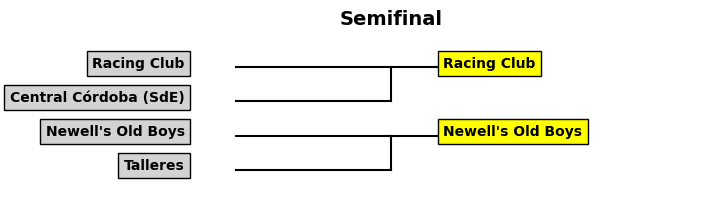

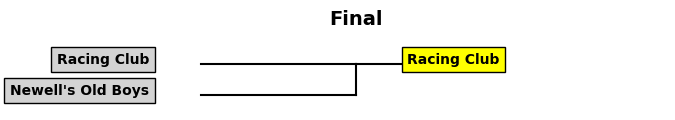

In [312]:
tabla_zonaA = list(tabla[tabla["Equipo"].isin(equipos_zonaA)][0:8]["Equipo"])
tabla_zonaB = list(tabla[tabla["Equipo"].isin(equipos_zonaB)][0:8]["Equipo"])
tabla_zonaB = tabla_zonaB[::-1]

Octavos = pd.DataFrame({"Equipo1": tabla_zonaA,
                        "Equipo2": tabla_zonaB
                        })

df_merged_octavos = Octavos.merge(df_Historial_Partidos, how="left", left_on=["Equipo1", "Equipo2"], right_on=["Equipo1", "Equipo2"])
df_merged_octavos = df_merged_octavos.merge(df_RTJ2024, left_on="Equipo1", right_on="Equipo", how="left", suffixes=("_local", ""))
df_merged_octavos = df_merged_octavos.merge(df_estadisticas, left_on="Equipo1", right_on="Equipo", how="left", suffixes=("_local", ""))
df_merged_octavos = df_merged_octavos.merge(df_RTJ2024, left_on="Equipo2", right_on="Equipo", how="left", suffixes=("", "_visitante"))
df_merged_octavos = df_merged_octavos.merge(df_estadisticas, left_on="Equipo2", right_on="Equipo", how="left", suffixes=("", "_visitante"))
df_merged_octavos.drop(columns=["Equipo_local", "Equipo_visitante"], inplace=True)

#Prediccion
X_octavos = df_merged_octavos[["PV", "PE", "PD", "Puntaje_TACT" , "RTJ2024" , "efectividad_L", "%victorias_L" , "%empates_L" , "%derrota_L"  , "xg" ,	"Puntaje_TACT_visitante",	"RTJ2024_visitante", "efectividad_V_visitante", "%victorias_V_visitante", "%empates_V_visitante", "%derrota_V_visitante", "xg_visitante"]]
df_merged_octavos["Pred_Goles_Local"] = modelo_local.predict(X_octavos)
df_merged_octavos["Pred_Goles_Visitante"] = modelo_visitante.predict(X_octavos) *1.1
umbral_empate = 0
df_merged_octavos["Pred_Resultado"] = df_merged_octavos.apply(lambda row: calcular_resultado(row, umbral_empate), axis=1)
df_merged_octavos["Vs"] = "Vs."

grafico_eliminatoria(df_merged_octavos)

cuartos = eliminatorias(df_merged_octavos)
grafico_eliminatoria(cuartos)
semis = eliminatorias(cuartos)
grafico_eliminatoria(semis)
final = eliminatorias(semis)
grafico_eliminatoria(final)

Campeon del torneo: 
 Racing Club


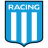

In [222]:
if final["Pred_Resultado"].iloc[0] == 1:
    ganador = final["Equipo1"].iloc[0]
    print("Campeon del torneo: \n", ganador)
    path = f"logos/{ganador}.png"
else:
    ganador = final["Equipo2"].iloc[0]
    print("Campeon del torneo: \n", ganador)
    path = f"logos/{ganador}.png"
Image.open(path)